# Import Required Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read and prepare the telescope dataset

In [73]:
telescope_data = pd.read_csv("datasets/telescope_data.csv", index_col=0)
telescope_data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# 1. Data Rebalancing

In [79]:

# shuffle data to avoid bias in slicing it
telescope_data = telescope_data.sample(frac=1).reset_index(drop=True)
class_col = "class"

# Separate gamma samples for reference
gamma = telescope_data[telescope_data[class_col] == 'g']

# Count samples per class
hadron_rows = telescope_data[class_col].value_counts().iloc[0]  # Hadron count (6688)
gamma_rows = telescope_data[class_col].value_counts().iloc[1]   # Gamma count (12332)

# Downsample the majority class (gamma) to balance the dataset
telescope_data = telescope_data.drop(
    telescope_data[telescope_data[class_col].eq('g')]
    .sample(hadron_rows - gamma_rows).index
)

# Separate features and target
X = telescope_data.iloc[:, :-1]
y = telescope_data[class_col]

# normalization
# we chosed to normalize our data to avoid the dominance of the features that have a wide range on the other features
X_min = X.min()
X_max = X.max()
X_normalized = (X - X_min) / (X_max - X_min)

# Combine standardized features with target
telescope_data = pd.concat([X_normalized, y], axis=1)

# Display to verify
display(X)
display(y)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,0.070819,0.047418,0.222206,0.460052,0.331605,0.421368,0.540433,0.512538,0.055083,0.411421
1,0.288894,0.077312,0.373034,0.204455,0.159727,0.516006,0.675800,0.584652,0.793455,0.355685
2,0.160830,0.089300,0.408516,0.245028,0.210550,0.469270,0.686331,0.562494,0.120720,0.417278
3,0.186239,0.092308,0.399172,0.211160,0.152171,0.510472,0.675754,0.564263,0.036826,0.442193
4,0.107346,0.035543,0.242815,0.486533,0.360498,0.453990,0.609863,0.542559,0.559679,0.351721
...,...,...,...,...,...,...,...,...,...,...
13371,0.052157,0.054323,0.148876,0.699284,0.630019,0.435426,0.549466,0.569430,0.193898,0.302931
13372,0.349599,0.165456,0.497250,0.098534,0.074530,0.325313,0.744437,0.498468,0.059131,0.420333
13373,0.231926,0.294797,0.627912,0.112967,0.093199,0.380477,0.625301,0.667009,0.338554,0.669801
13374,0.509136,0.078760,0.283737,0.313217,0.287005,0.563821,0.780081,0.478168,0.321724,0.423986


0        g
1        h
2        g
3        g
4        h
        ..
13371    g
13372    h
13373    h
13374    h
13375    g
Name: class, Length: 13376, dtype: object

# 2. Splitting Data

In [80]:
# Get total number of rows in the dataset
total_rows = telescope_data.shape[0]

# Define split ratios
training_set_ratio = 0.7
validation_set_ratio = 0.15
test_set_ratio = 0.15

# Calculate split indices
training_end = int(total_rows * training_set_ratio)
validation_end = int(total_rows * (training_set_ratio + validation_set_ratio))

# Split the dataset into training, validation, and test sets
training_set = telescope_data[:training_end]
validation_set = telescope_data[training_end:validation_end]
test_set = telescope_data[validation_end:]

# display(training_set)
# display(validation_set)
# display(test_set)

# 3. KNN Classifier (Manual Implementation)

Best k = 21, Accuracy = 83.6989%


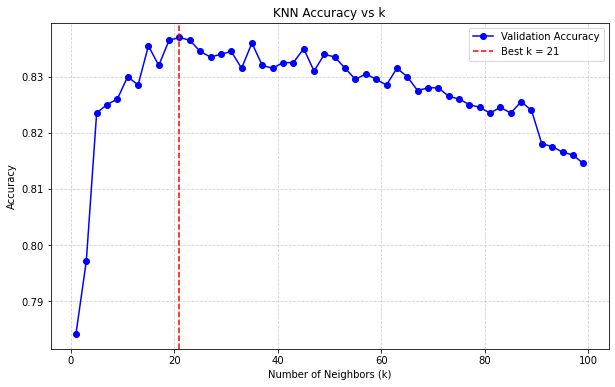

In [81]:
from collections import Counter
from scipy.stats import mode
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)

    def predict(self, X_validation):
        X_validation = np.array(X_validation)

        # Compute Euclidean distances (vectorized)
        distances = np.sqrt(
            np.sum((X_validation[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]) ** 2, axis=2)
        )

        # Get indices of k nearest neighbors
        k_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]

        # Retrieve corresponding labels
        k_nearest_labels = self.y_train[k_indices]

        # Compute majority vote using np.unique
        predictions = []
        for labels in k_nearest_labels:
            unique_labels, counts = np.unique(labels, return_counts=True)
            predictions.append(unique_labels[np.argmax(counts)])

        return np.array(predictions)


# --- Prepare training and validation data ---
X_train = training_set.iloc[:, :-1].values
y_train = training_set[class_col].values

X_validation = validation_set.iloc[:, :-1].values
y_validation = validation_set[class_col].values

# --- Try different k values ---
k_values = range(1, 101, 2)
accuracies = []

for k in k_values:
    classifier = KNN(k=k)
    classifier.fit(X_train, y_train)
    
    predictions = classifier.predict(X_validation)
    accuracy = np.mean(predictions == y_validation)
    accuracies.append(accuracy)

# --- Best result ---
best_k = k_values[np.argmax(accuracies)]
print(f"Best k = {best_k}, Accuracy = {100 * max(accuracies):.4f}%")


# --- Plot Accuracy vs k ---
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.title("KNN Accuracy vs k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()




# Manual Classification Evaluation

Accuracy: 79.46%

Per-class metrics:
  Class  Precision    Recall  F1-score
0     g   0.749400  0.904348  0.819615
1     h   0.869221  0.677652  0.761574

Confusion Matrix:


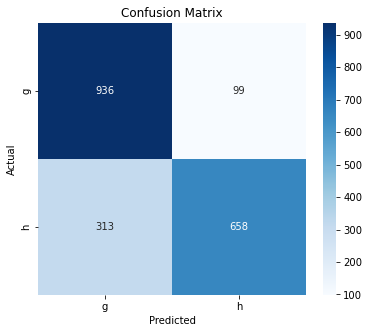

In [ ]:
def evaluate_classification(y_target, y_predicted):
    # Convert inputs to NumPy arrays for consistency
    y_target = np.array(y_target)
    y_predicted = np.array(y_predicted)

    # Get all unique class labels
    classes = np.unique(np.concatenate((y_target, y_predicted)))

    # Initialize confusion matrix
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)

    # Fill confusion matrix
    for i in range(len(y_target)):
        true_idx = np.where(classes == y_target[i])[0][0]
        pred_idx = np.where(classes == y_predicted[i])[0][0]
        conf_matrix[true_idx, pred_idx] += 1
    
    # Calculate per-class metrics
    precision, recall, f1 = [], [], []

    for i in range(len(classes)):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP

        prec = TP / (TP + FP) if (TP + FP) != 0 else 0
        rec = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = (2 * prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1.append(f1_score)

    # Compute overall accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    # Combine metrics into a DataFrame
    metrics_df = pd.DataFrame({
        'Class': classes,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

    return accuracy, metrics_df, conf_matrix


# Evaluate model performance on validation set
y_target = validation_set[class_col].to_numpy()
y_predicted = predictions

accuracy, metrics_df, conf_matrix = evaluate_classification(y_target, y_predicted)

# Display results
print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Per-class metrics:")
print(metrics_df)

# Plot confusion matrix
print("\nConfusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=metrics_df['Class'],
            yticklabels=metrics_df['Class'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Manual implementation final test

In [ ]:
X_manual_test = test_set.iloc[:, :-1]
y_manual_test = test_set[class_col]

manual_test_prediction = classifier.predict(X_manual_test)

# Final test evaluation

Accuracy: 79.72%

Per-class metrics:
  Class  Precision    Recall  F1-score
0     g   0.757225  0.890291  0.818385
1     h   0.858040  0.699079  0.770446

Confusion Matrix:


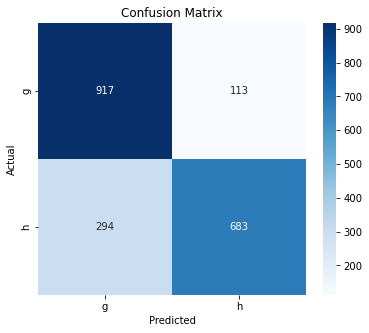

In [62]:

y_manual_test = y_manual_test.to_numpy()
accuracy, metrics_df, conf_matrix = evaluate_classification(y_manual_test,manual_test_prediction)

print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Per-class metrics:")
print(metrics_df)
print("\nConfusion Matrix:")
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=metrics_df['Class'],
            yticklabels=metrics_df['Class'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 4.KNN implementation using scikit-learn

In [82]:


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Separate features and target
X = telescope_data.iloc[:, :-1]
Y = telescope_data[class_col]

# Step 1: Split into training + temp (which will later be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=0
)

# Step 2: Split the temp data into validation and test sets equally (15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0
)

clf = KNeighborsClassifier(n_neighbors=25)
clf.fit(X_train, y_train)

,n_neighbors,25
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [83]:
y_val_pred = clf.predict(X_val)
print("validation set predictions: {}".format(y_val_pred))

validation set predictions: ['g' 'g' 'g' ... 'g' 'g' 'g']


In [84]:
print("validation set accuracy: {:.2f}%".format(clf.score(X_val, y_val) * 100))

validation set accuracy: 80.86%


# classification evaluation with scikit-learn

Validation Accuracy: 80.86%

Classification Report:
              precision    recall  f1-score   support

           g       0.77      0.89      0.83      1026
           h       0.86      0.72      0.79       980

    accuracy                           0.81      2006
   macro avg       0.82      0.81      0.81      2006
weighted avg       0.82      0.81      0.81      2006



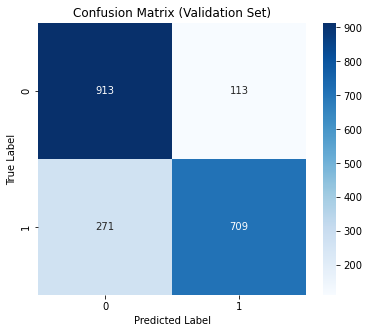

In [85]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Final test

In [86]:
test_prediction = clf.predict(X_test)

Validation Accuracy: 81.66%

Classification Report:
              precision    recall  f1-score   support

           g       0.77      0.90      0.83      1011
           h       0.88      0.73      0.80       996

    accuracy                           0.82      2007
   macro avg       0.83      0.82      0.82      2007
weighted avg       0.83      0.82      0.82      2007



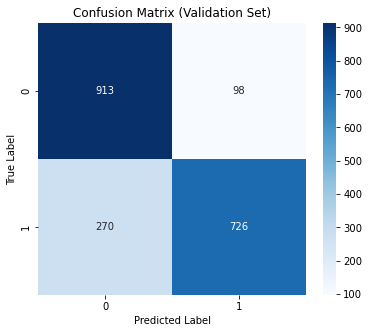

In [42]:
# classification evaluation with scikit-learn

accuracy = accuracy_score(y_test, test_prediction)
print(f"Validation Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, test_prediction))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_prediction)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()